## **Data Visualization**

### Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

### Load The Dataset


In [7]:
df_origin = pd.read_csv('../data/ireland-news-headlines.csv')
df = df_origin.copy()

### Analayze The Dataset

Arrangement of the DataFrame.

In [8]:
df['publish_date'] = pd.to_datetime(df['publish_date'], format='%Y%m%d')
df['year'] = df['publish_date'].dt.year
# df['month'] = df['publish_date'].dt.month
# df['day'] = df['publish_date'].dt.day
df.drop('publish_date', axis=1, inplace=True)
print(df.shape)
print(df.head())

(1611495, 3)
  headline_category                                    headline_text  year
0              news         UUP sees possibility of voting Major out  1996
1              news   Pubs targeted as curbs on smoking are extended  1996
2              news  Papers reveal secret links with O'Neill cabinet  1996
3              news      Domestic chaos as Italy takes EU presidency  1996
4              news     Learning about the star to which we owe life  1996


#### Erase duplicated rows and nan cells

In [9]:
print(f'Number of duplicated rows: {df.duplicated().sum()}')

Number of duplicated rows: 76264


In [10]:
df.drop_duplicates(inplace=True)
df = df.dropna() 
df = df.reset_index()
df = df.iloc[:,1:]
print(df.shape)

(1535225, 3)


#### Visualization

Split the headline category to 4 levels

In [13]:
df[['headline_category', 'headline_category_2', 'headline_category_3', 'headline_category_4']] = df['headline_category'].str.split('.', expand=True)
Num_pri_classes = len(df['headline_category'].unique())
print(f'Number of primary classes: {Num_pri_classes}')
Names_pri_classes = df['headline_category'].unique()
print(f'The classes are: {Names_pri_classes}')
Num_all_classes = len(df_origin['headline_category'].unique())
print(f'Number of all the classes: {Num_all_classes}')

Number of primary classes: 6
The classes are: ['news' 'culture' 'opinion' 'business' 'sport' 'lifestyle']
Number of all the classes: 103


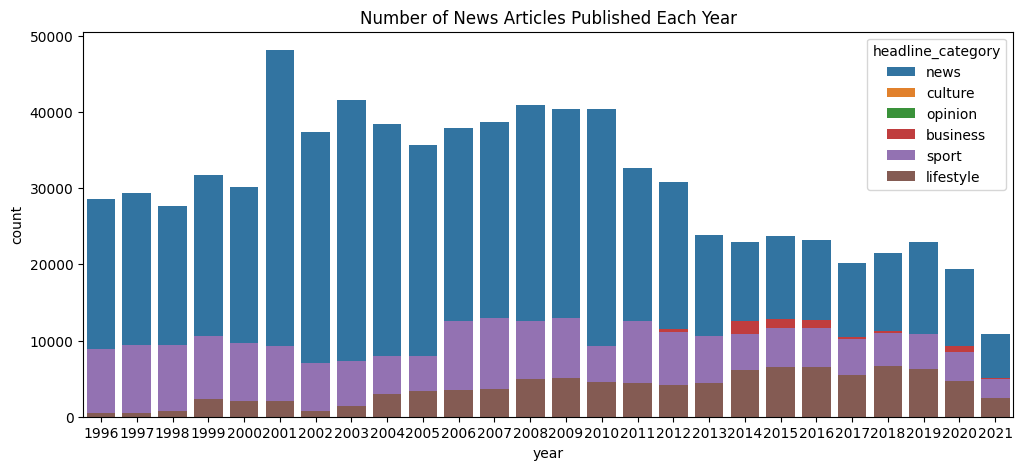

In [31]:
plt.figure(figsize=(12,5))
ax = sns.countplot(x='year',hue='headline_category',dodge=False, data=df)
plt.title('Number of News Articles Published Each Year')
plt.show()


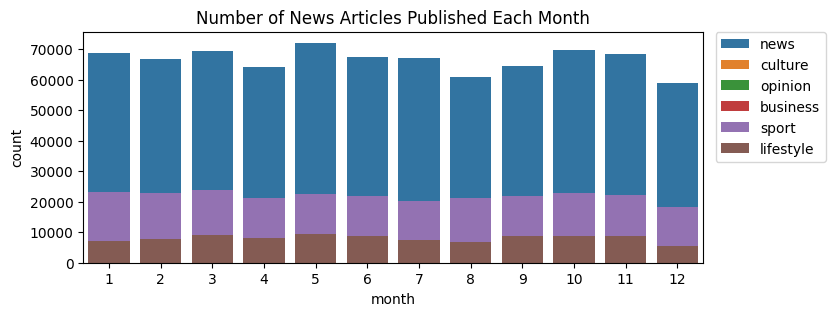

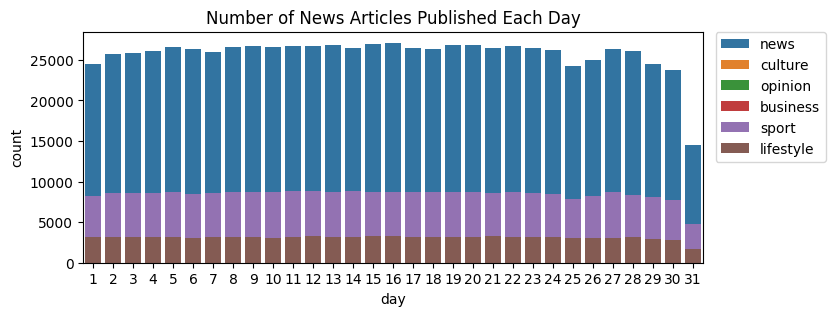

In [32]:
plt.figure(figsize=(8,3))
ax = sns.countplot(x='month',hue='headline_category',dodge=False, data=df)
plt.title('Number of News Articles Published Each Month')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.figure(figsize=(8,3))
ax = sns.countplot(x='day',hue='headline_category',dodge=False, data=df)
plt.title('Number of News Articles Published Each Day')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()


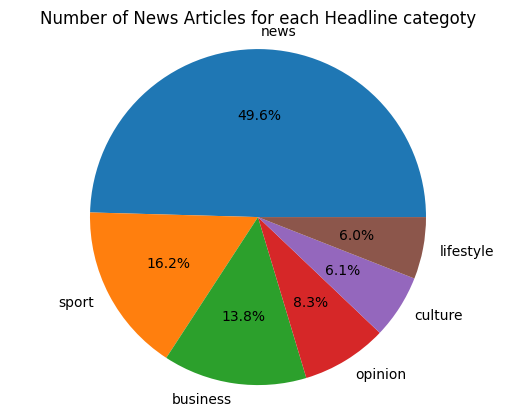

In [29]:
category_counts = df['headline_category'].value_counts()
plt.figure()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Number of News Articles for each Headline categoty')
# plt.title('Distribution of Categories')
plt.axis('equal')
plt.show()

Display of repeated words in the data by title in a word cloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
PUNCT_TO_REMOVE = '_!"#$%&\'()*+,-.:/;<=>?@[\\]^{|}~`'

word_clouds = []
for cat in df['headline_category'].unique():
    
    df3 = df[df['headline_category'] == cat] 
    df3 = df3['headline_text'].astype(str)
    text = ' '.join(df3.tolist())

    word_frequencies = {}
    for word in text.lower().split():
        if word not in PUNCT_TO_REMOVE:
            if word not in STOPWORDS:
                if word not in word_frequencies:
                    word_frequencies[word] = 0
                word_frequencies[word] += 1

    wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_frequencies)
    word_clouds.append(wordcloud)
    

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), facecolor=None)
axes[0, 0].imshow(word_clouds[0])
axes[0, 0].set_title('news')
axes[0, 0].axis('off')
axes[0, 1].imshow(word_clouds[1])
axes[0, 1].set_title('culture')
axes[0, 1].axis('off')
axes[0, 2].imshow(word_clouds[2])
axes[0, 2].set_title('opinion')
axes[0, 2].axis('off')
axes[1, 0].imshow(word_clouds[3])
axes[1, 0].set_title('business')
axes[1, 0].axis('off')
axes[1, 1].imshow(word_clouds[4])
axes[1, 1].set_title('sport')
axes[1, 1].axis('off')
axes[1, 2].imshow(word_clouds[5])
axes[1, 2].set_title('lifestyle')
axes[1, 2].axis('off')
plt.tight_layout(pad=0)
    
plt.show()

#### Clean The Data

* converting all letters to lower case
* removing numbers
* removing punctuations
* removing stop words
* Inflections of a word

In [14]:
df.insert(2, "clean_headline_text",  None)

In [8]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string

# nltk.download('wordnet')
# nltk.download('omw-1.4')
stemmer= PorterStemmer()
stopwords = nltk.corpus.stopwords.words('english')
lemmatizer = WordNetLemmatizer()

for i, text in enumerate(df["headline_text"]):
    clean_text = text.lower() # converting all letters to lower case
    clean_text = re.sub(r'\d+', '', clean_text) # removing numbers
    clean_text = clean_text.translate(str.maketrans("","", string.punctuation)) # removing punctuations
    clean_text = clean_text.strip() # removing whitespaces
    wo_sw = ''
    for word in clean_text.split():
        if word not in stopwords: # removing stop words
            word = stemmer.stem(word)
            word = lemmatizer.lemmatize(word) # Inflections of a word
            wo_sw += word + ' '
    clean_text = wo_sw 
    
    df["clean_headline_text"][i] = clean_text

C:\Users\alon\AppData\Local\Temp\ipykernel_22872\2618674690.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["clean_headline_text"][i] = clean_text


In [9]:
df.to_csv('../data/ireland-news-headlines-cleaned.csv')  

In [ ]:
from wordcloud import WordCloud

word_clouds = []
for cat in df['headline_category'].unique():
    
    df3 = df[df['headline_category'] == cat] 
    df3 = df3['clean_headline_text'].astype(str)
    text = ' '.join(df3.tolist())

    word_frequencies = {}
    for word in text:
        if word not in word_frequencies:
            word_frequencies[word] = 0
        word_frequencies[word] += 1

    wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=100).generate_from_frequencies(word_frequencies)
    word_clouds.append(wordcloud)
    

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), facecolor=None)
axes[0, 0].imshow(word_clouds[0])
axes[0, 0].set_title('news')
axes[0, 0].axis('off')
axes[0, 1].imshow(word_clouds[1])
axes[0, 1].set_title('culture')
axes[0, 1].axis('off')
axes[0, 2].imshow(word_clouds[2])
axes[0, 2].set_title('opinion')
axes[0, 2].axis('off')
axes[1, 0].imshow(word_clouds[3])
axes[1, 0].set_title('business')
axes[1, 0].axis('off')
axes[1, 1].imshow(word_clouds[4])
axes[1, 1].set_title('sport')
axes[1, 1].axis('off')
axes[1, 2].imshow(word_clouds[5])
axes[1, 2].set_title('lifestyle')
axes[1, 2].axis('off')
plt.tight_layout(pad=0)
    
plt.show()

#### Models

##### t-SNE

In [10]:
# t-SNE
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.manifold import TSNE

# # Create a TF-IDF vectorizer object
# vectorizer = TfidfVectorizer()

# # Convert article titles to TF-IDF vectors
# tfidf_vectors = vectorizer.fit_transform(df2['headline_text'])

# # Perform t-SNE on the TF-IDF vectors to reduce their dimensionality to 2D
# tsne = TSNE(n_components=2, random_state=42, init="random")
# tsne_vectors = tsne.fit_transform(tfidf_vectors)

# # Plot the 2D t-SNE vectors
# plt.figure(figsize=(10, 10))
# plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], marker='.')
# plt.title('t-SNE Visualization of Article Titles')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.show()

##### LDA